In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
datasets = tf.keras.datasets
layers =  tf.keras.layers
models = tf.keras.models
losses = tf.keras.losses
optimizers = tf.keras.optimizers 
metrics = tf.keras.metrics
preprocessing_image = tf.keras.preprocessing.image

In [3]:
!tar -xvf "drive/MyDrive/cars_train.tar"

Выходные данные были обрезаны до нескольких последних строк (5000).
cars_train/03145.jpg
cars_train/03146.jpg
cars_train/03147.jpg
cars_train/03148.jpg
cars_train/03149.jpg
cars_train/03150.jpg
cars_train/03151.jpg
cars_train/03152.jpg
cars_train/03153.jpg
cars_train/03154.jpg
cars_train/03155.jpg
cars_train/03156.jpg
cars_train/03157.jpg
cars_train/03158.jpg
cars_train/03159.jpg
cars_train/03160.jpg
cars_train/03161.jpg
cars_train/03162.jpg
cars_train/03163.jpg
cars_train/03164.jpg
cars_train/03165.jpg
cars_train/03166.jpg
cars_train/03167.jpg
cars_train/03168.jpg
cars_train/03169.jpg
cars_train/03170.jpg
cars_train/03171.jpg
cars_train/03172.jpg
cars_train/03173.jpg
cars_train/03174.jpg
cars_train/03175.jpg
cars_train/03176.jpg
cars_train/03177.jpg
cars_train/03178.jpg
cars_train/03179.jpg
cars_train/03180.jpg
cars_train/03181.jpg
cars_train/03182.jpg
cars_train/03183.jpg
cars_train/03184.jpg
cars_train/03185.jpg
cars_train/03186.jpg
cars_train/03187.jpg
cars_train/03188.jpg
cars_tra

In [4]:
import os
import scipy.io
from PIL import Image
from torchvision import transforms
import torch
from tqdm import tqdm

class MyDataset(object):
    def __init__(self, path, path_mat):
        self.path = path
        self.path_mat = path_mat
        self.imgs = list(sorted(os.listdir(self.path)))
        self.mat = scipy.io.loadmat(self.path_mat)['annotations'][0]

    def __getitem__(self, idx):
        file_image = os.path.join(self.path, str(self.imgs[idx]))
        target = self.mat[idx][-2]

        img = Image.open(file_image).convert("RGB").resize((32, 32))

        return  np.array(img), target

    def __len__(self):
        return len(self.imgs)

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MyDataset(
    "cars_train",
    "drive/MyDrive/cars_train_annos.mat"
)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=collate_fn)

x_train = list()
y_train = list()

for img, label in tqdm(data_loader):
    y = np.zeros(196)
    y[label[0][0][0] - 1] = 1
    x = img[0]
    x_train.append(x)
    y_train.append(y)

x_train = np.array(x_train)
y_train = np.array(y_train)

100%|██████████| 8144/8144 [01:23<00:00, 98.03it/s] 


In [5]:
train_datagen = preprocessing_image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

train_generator = train_datagen.flow(x=x_train, y=y_train, batch_size=32, shuffle=True)

In [6]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    sq1x1 = "squeeze1x1"
    exp1x1 = "expand1x1"
    exp3x3 = "expand3x3"
    relu = "relu_"
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3

    x = layers.Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = layers.Activation('relu', name=s_id + relu + sq1x1)(x)

    left = layers.Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = layers.Activation('relu', name=s_id + relu + exp1x1)(left)

    right = layers.Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = layers.Activation('relu', name=s_id + relu + exp3x3)(right)

    x = layers.concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

def SqueezeNet(input_shape=(32,32,3), classes=196):

    img_input = layers.Input(shape=input_shape)

    x = layers.Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = layers.Activation('relu', name='relu_conv1')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = layers.Dropout(0.5, name='drop9')(x)

    x = layers.Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = layers.Activation('relu', name='relu_conv10')(x)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Activation('softmax', name='loss')(x)

    model = models.Model(img_input, out, name='squeezenet')

    return model

In [7]:
def compile_model(model):
    loss = losses.categorical_crossentropy
    optimizer = optimizers.Adam(lr=0.0001)
    metric = [metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]
    model.compile(optimizer, loss, metric)

    return model

In [8]:
sn = SqueezeNet()
sn = compile_model(sn)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
history = sn.fit_generator(
    train_generator,
    steps_per_epoch=250,
    epochs=100)

Epoch 1/100
  1/250 [..............................] - ETA: 16s - loss: 5.1953 - categorical_accuracy: 0.0312 - top_k_categorical_accuracy: 0.0625

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


250/250 [==============================] - 5s 21ms/step - loss: 5.1769 - categorical_accuracy: 0.0143 - top_k_categorical_accuracy: 0.0569
Epoch 2/100
250/250 [==============================] - 5s 20ms/step - loss: 5.1719 - categorical_accuracy: 0.0133 - top_k_categorical_accuracy: 0.0597
Epoch 3/100
250/250 [==============================] - 5s 20ms/step - loss: 5.1719 - categorical_accuracy: 0.0162 - top_k_categorical_accuracy: 0.0567
Epoch 4/100
250/250 [==============================] - 5s 20ms/step - loss: 5.1647 - categorical_accuracy: 0.0134 - top_k_categorical_accuracy: 0.0589
Epoch 5/100
250/250 [==============================] - 5s 20ms/step - loss: 5.1646 - categorical_accuracy: 0.0133 - top_k_categorical_accuracy: 0.0572
Epoch 6/100
250/250 [==============================] - 5s 20ms/step - loss: 5.1599 - categorical_accuracy: 0.0158 - top_k_categorical_accuracy: 0.0597
Epoch 7/100
250/250 [==============================] - 5s 20ms/step - loss: 5.1591 - categorical_accuracy:

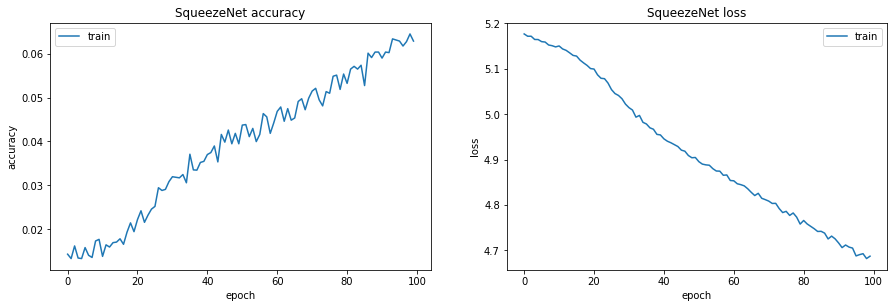

In [14]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

plot_accuracy_and_loss(history)